In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Loading Data

In [ ]:
# Configuration
NUM_CLASSES_SUBSET = 10
IMG_SIZE = 160
base_dir = "images"
occlusion_types = ["masked", "sunglasses", "neutral"]

# Count images (your counting code remains unchanged)
print("Counting neutral/no occlusion images...")
neutral_images_count = sum(
    len(os.listdir(os.path.join(base_dir, "neutral", person_dir)))
    for person_dir in os.listdir(os.path.join(base_dir, "neutral"))
    if os.path.isdir(os.path.join(base_dir, "neutral", person_dir))
)
print(f"Neutral images: {neutral_images_count}")

print("Counting sunglasses images...")
sunglasses_images_count = sum(
    len(os.listdir(os.path.join(base_dir, "sunglasses", person_dir)))
    for person_dir in os.listdir(os.path.join(base_dir, "sunglasses"))
    if os.path.isdir(os.path.join(base_dir, "sunglasses", person_dir))
)
print(f"Sunglasses images: {sunglasses_images_count}")

print("Counting masked images...")
masked_images_count = sum(
    len(os.listdir(os.path.join(base_dir, "masked", person_dir)))
    for person_dir in os.listdir(os.path.join(base_dir, "masked"))
    if os.path.isdir(os.path.join(base_dir, "masked", person_dir))
)
print(f"Masked images: {masked_images_count}")

print("Counting total images...")
total_images = sum(
    len(os.listdir(os.path.join(base_dir, occlusion_type, person_dir)))
    for occlusion_type in occlusion_types if os.path.exists(os.path.join(base_dir, occlusion_type))
    for person_dir in os.listdir(os.path.join(base_dir, occlusion_type))
    if os.path.isdir(os.path.join(base_dir, occlusion_type, person_dir))
)
print(f"Total images: {total_images}")

# Containers for data
images, labels = [], []
label_names = {}

# Load OpenCV's pre-trained Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to process a single image, filtering out non-human faces
def process_image(img_path, label):
    try:
        # Load image as BGR and then create a grayscale version for face detection
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            return None, None

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Perform face detection
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)  # Adjust depending on your images
        )

        # If no face is detected, skip this image
        if len(faces) == 0:
            return None, None

        # Resize and normalize the image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0

        return img, label
    except Exception as e:
        # Optionally log e for debugging
        return None, None

def load_images_by_type(occlusion_type, total_images, max_persons=None):
    images = []
    labels = []

    occlusion_path = os.path.join(base_dir, occlusion_type)

    if not os.path.exists(occlusion_path):
        print(f"[WARNING] Directory {occlusion_path} does not exist. Skipping.")
        return images, labels

    tasks = []

    # Get all person directories and limit them to a subset if needed
    all_person_dirs = [d for d in os.listdir(occlusion_path) if os.path.isdir(os.path.join(occlusion_path, d))]
    all_person_dirs = all_person_dirs[:NUM_CLASSES_SUBSET]

    with ThreadPoolExecutor(max_workers=8) as executor:
        for person_dir in all_person_dirs:
            person_path = os.path.join(occlusion_path, person_dir)

            # Clean labels
            clean_label = person_dir.replace("_wearing_sunglasses", "").replace("_wearing_mask", "")
            
            if clean_label not in label_names:
                label_names[clean_label] = len(label_names)

            label = label_names[clean_label]

            for img_file in os.listdir(person_path):
                if img_file.endswith('.jpg'):
                    img_path = os.path.join(person_path, img_file)
                    tasks.append(executor.submit(process_image, img_path, label))

        for future in tqdm(tasks, total=total_images, desc=f"Processing '{occlusion_type}' images", ncols=100):
            img, label = future.result()
            if img is not None:
                images.append(img)
                labels.append(label)

    return images, labels

# Start loading images and display samples

# For neutral images
neutral_images, neutral_labels = load_images_by_type("neutral", neutral_images_count)
reverse_label_names = {v: k for k, v in label_names.items()}
num_samples = 10
sample_indices = random.sample(range(len(neutral_images)), num_samples)
print("===== Neutral Image Samples With Faces =====")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    img = neutral_images[idx]
    label = neutral_labels[idx]
    ax = axes[i // 5, i % 5]
    ax.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    ax.set_title(f"Label: {label}\nDir: {reverse_label_names[label]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()

# For sunglasses images
sunglasses_images, sunglasses_labels = load_images_by_type("sunglasses", sunglasses_images_count)
reverse_label_names = {v: k for k, v in label_names.items()}
sample_indices = random.sample(range(len(sunglasses_images)), num_samples)
print("===== Sunglasses Image Samples With Faces =====")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    img = sunglasses_images[idx]
    label = sunglasses_labels[idx]
    ax = axes[i // 5, i % 5]
    ax.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    ax.set_title(f"Label: {label}\nDir: {reverse_label_names[label]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()

# For masked images
masked_images, masked_labels = load_images_by_type("masked", masked_images_count)
reverse_label_names = {v: k for k, v in label_names.items()}
sample_indices = random.sample(range(len(masked_images)), num_samples)
print("===== Masked Image Samples With Faces =====")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    img = masked_images[idx]
    label = masked_labels[idx]
    ax = axes[i // 5, i % 5]
    ax.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    ax.set_title(f"Label: {label}\nDir: {reverse_label_names[label]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Dataset Loaded: {len(masked_images) + len(sunglasses_images) + len(neutral_images)} images, {len(label_names)} unique labels.")


Counting neutral/no occlusion images...
Neutral images: 5136
Counting sunglasses images...
Sunglasses images: 2374
Counting masked images...
Masked images: 317
Counting total images...
Total images: 7827


Processing 'neutral' images:   0%|                                         | 0/5136 [00:00<?, ?it/s]

## Train - Test Split

In [51]:
def split_dataset(images, labels, occlusion_type):
    X_train, X_test, y_train, y_test = train_test_split(
        np.array(images), np.array(labels), test_size=0.2, random_state=42
    )
    print(f"\n{occlusion_type.capitalize()} data: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples.")
    return X_train, X_test, y_train, y_test

X_train_neutral, X_test_neutral, y_train_neutral, y_test_neutral = split_dataset(neutral_images, neutral_labels, "neutral")
X_train_sunglasses, X_test_sunglasses, y_train_sunglasses, y_test_sunglasses = split_dataset(sunglasses_images, sunglasses_labels, "sunglasses")
X_train_masked, X_test_masked, y_train_masked, y_test_masked = split_dataset(masked_images, masked_labels, "masked")

#Combine Training Sets
X_train = np.concatenate([X_train_neutral, X_train_sunglasses, X_train_masked], axis=0)
y_train = np.concatenate([y_train_neutral, y_train_sunglasses, y_train_masked], axis=0)

X_test = np.concatenate([X_test_neutral, X_test_sunglasses, X_test_masked], axis=0)
y_test = np.concatenate([y_test_neutral, y_test_sunglasses, y_test_masked], axis=0)


Neutral data: 1184 train samples, 296 test samples.

Sunglasses data: 595 train samples, 149 test samples.

Masked data: 168 train samples, 43 test samples.


## Building Models
Model A: A simple CNN with two convolutional layers.
Model B: A deeper CNN with three convolutional layers and dropout.
Model C: A variant with more filters and batch normalization.

In [52]:
num_classes = len(label_names)

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights="imagenet")

base_model.trainable = False  # Freeze the base model initially
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 80)             │        10,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,432,272 (9.28 MB)

 Trainable params: 174,288 (680.81 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training Models

In [53]:
earlystop = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[earlystop]
)


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 365ms/step - accuracy: 0.0390 - loss: 4.3853 - val_accuracy: 0.0963 - val_loss: 3.9006
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.1021 - loss: 3.7856 - val_accuracy: 0.1598 - val_loss: 3.5974
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 523ms/step - accuracy: 0.1599 - loss: 3.3619 - val_accuracy: 0.1844 - val_loss: 3.4198
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.2233 - loss: 3.1111 - val_accuracy: 0.2336 - val_loss: 3.2606
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.2556 - loss: 2.8902 - val_accuracy: 0.2766 - val_loss: 3.0618
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.3193 - loss: 2.6099 - val_accuracy: 0.2705 - val_loss: 2.9944
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.3607 - loss: 2.4392 - val_accuracy: 0.3156 - val_loss: 2.8727
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 394ms/step - accuracy: 0.4128 - loss: 2.2156 - 

## Analysis

Test Accuracy: 0.406, Test Loss: 2.475
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.50      0.18         2
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         7
           3       0.14      0.20      0.17         5
           4       0.50      0.29      0.36         7
           5       0.00      0.00      0.00         5
           6       0.67      0.50      0.57         4
           7       0.60      0.25      0.35        12
           8       0.75      0.38      0.50         8
           9       0.67      0.29      0.40         7
          10       0.00      0.00      0.00         3
          11       0.14      0.12      0.13         8
          12       0.36      0.59      0.44        17
          13       0.18      0.20      0.19        15
          14       0.00      0.00      0.00         7
          15       1.00      0.

C:\Users\grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

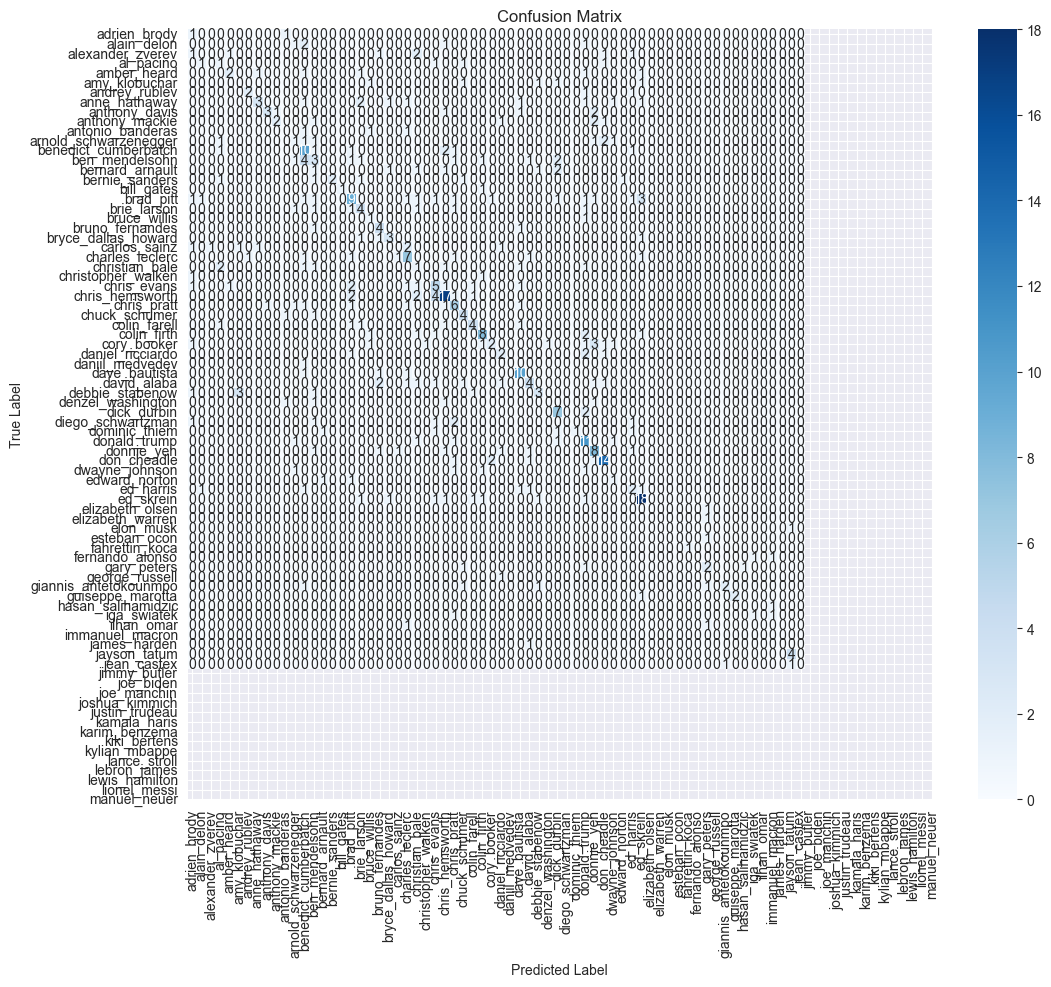

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.3f}, Test Loss: {test_loss:.3f}")

# Predictions and classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[k for k in label_names],
            yticklabels=[k for k in label_names])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


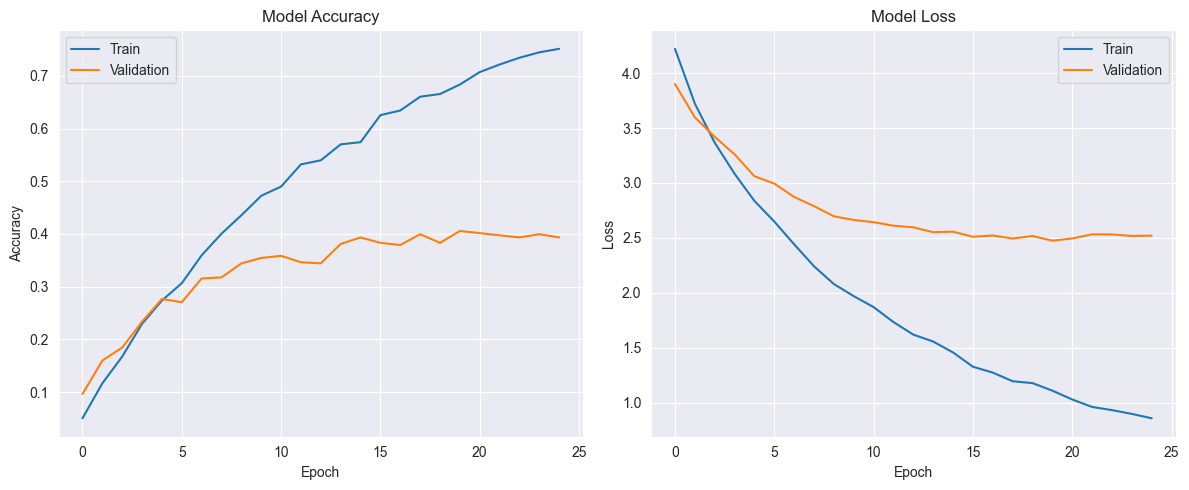

In [55]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
